## Part II: Predictive Modeling

#### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn import ensemble
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import Ridge, BayesianRidge
from sklearn.linear_model import Lasso
from sklearn.naive_bayes import GaussianNB
from df_after_transform import df_after_transform
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn import linear_model

## Corn Model

#### Load Commodity DF and Create Holdout Set and Split X and y

In [2]:
#Load in the Final Commodities DF as gotten from data_cleaning.ipynb file
Commodities_DF = pd.read_csv('output_data/commodities_df.csv')

#Add market risk premium column
Commodities_DF['sp500_rets'] = (np.log(Commodities_DF['sp500_Price'].shift(-1)) 
                                       - np.log(Commodities_DF['sp500_Price']))

# using rf rate of 2.92%
Commodities_DF['market_risk_prem'] = ((Commodities_DF['sp500_rets'].rolling(60, min_periods = 0).mean()) - (0.0292/12))

# use weighted avg to ensure positive market risk premiums
Commodities_DF['market_risk_prem'] = (0.2 * Commodities_DF['market_risk_prem']) + (0.8 * 0.00407)

In [3]:
#Impute NaN values
Commodities_DF['realized_ret_corn'].fillna(value=Commodities_DF['realized_ret_corn'].mean(), inplace=True)
Commodities_DF['realized_ret_soybeans'].fillna(value=Commodities_DF['realized_ret_soybeans'].mean(), inplace=True)
Commodities_DF['realized_ret_wheat'].fillna(value=Commodities_DF['realized_ret_soybeans'].mean(), inplace=True)

In [4]:
#Split off X and y
y = Commodities_DF['realized_ret_corn'] #y
Commodities_DF_X = Commodities_DF.drop(['realized_ret_corn', 'realized_ret_soybeans', 
                                       'realized_ret_wheat'], axis=1) #x's

#Train data is first 80% of our DF, test (holdout) data is last 20% of our DF
X_train = Commodities_DF_X[0:288]
X_test = Commodities_DF_X[288:]
y_train = y[0:288]
y_test = y[288:]

#### EDA on Training Set

In [5]:
X_train.head()

,DATE,GDP,CPIAUCSL,UNRATE,Corn_Future_Price,C_PRCP,C_SNOW,C_TMAX,C_TMIN,sp500_Price,...,S_TMIN,Wheat_Future_Price,W_PRCP,W_SNOW,W_TMAX,W_TMIN,ret_gdp,ret_cpi,sp500_rets,market_risk_prem
0,1990-01-01,5872.701,127.5,5.4,NaN,0.0,0.0,22.0,-33.0,329.08,...,-200.0,NaN,5.0,0.0,39.0,-28.0,0.000000,0.003914,0.008503,0.004470
1,1990-02-01,5872.701,128.0,5.3,NaN,10.0,0.0,67.0,6.0,331.89,...,-239.0,NaN,30.0,33.0,11.0,-28.0,0.014761,0.004677,0.023966,0.006016
2,1990-03-01,5960.028,128.6,5.2,NaN,0.0,0.0,67.0,-72.0,339.94,...,-72.0,NaN,0.0,0.0,111.0,-17.0,0.000000,0.002330,-0.027255,0.003117
3,1990-04-01,5960.028,128.9,5.4,281.25,3.0,0.0,161.0,72.0,330.80,...,6.0,NaN,0.0,0.0,194.0,44.0,0.000000,0.001550,0.088001,0.007430
4,1990-05-01,5960.028,129.1,5.4,278.00,0.0,0.0,156.0,56.0,361.23,...,-39.0,NaN,0.0,0.0,139.0,17.0,0.009200,0.006178,-0.008926,0.006141


In [6]:
print("The number of (rows,columns) in the X_train dataset:", X_train.shape)

The number of (rows,columns) in the X_train dataset: (288, 24)


In [7]:
X_train.columns

Index(['DATE', 'GDP', 'CPIAUCSL', 'UNRATE', 'Corn_Future_Price', 'C_PRCP',
       'C_SNOW', 'C_TMAX', 'C_TMIN', 'sp500_Price', 'Soybeans_Future_Price',
       'S_PRCP', 'S_SNOW', 'S_TMAX', 'S_TMIN', 'Wheat_Future_Price', 'W_PRCP',
       'W_SNOW', 'W_TMAX', 'W_TMIN', 'ret_gdp', 'ret_cpi', 'sp500_rets',
       'market_risk_prem'],
      dtype='object')

In [8]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
GDP,288.0,11102.897649,3449.769312,5872.701000,7868.468000,10783.500000,14448.882000,17144.281000
CPIAUCSL,288.0,180.863545,31.124115,127.500000,154.500000,177.850000,211.409750,234.719000
UNRATE,288.0,6.125694,1.609867,3.800000,4.900000,5.700000,7.200000,10.000000
Corn_Future_Price,285.0,328.369298,156.024403,180.250000,220.250000,258.000000,377.000000,806.500000
C_PRCP,282.0,23.056738,73.197852,0.000000,0.000000,0.000000,0.000000,627.000000
C_SNOW,257.0,2.015564,14.938146,0.000000,0.000000,0.000000,0.000000,188.000000
C_TMAX,286.0,170.734266,116.018991,-100.000000,78.000000,183.000000,272.000000,367.000000
C_TMIN,285.0,53.884211,100.565534,-194.000000,-22.000000,67.000000,139.000000,239.000000
sp500_Price,288.0,994.826458,390.317814,304.000000,630.997500,1101.735000,1302.335000,1848.360000
Soybeans_Future_Price,285.0,777.411579,315.380729,421.000000,563.500000,632.500000,940.380000,1754.370000


In [9]:
na_df = pd.DataFrame(X_train.isna().sum())
na_df.rename(columns = {0:'number_na'}, inplace = True)

na_df['fraction_na'] = (na_df['number_na']/len(X_train)).round(2)

na_df

,number_na,fraction_na
DATE,0,0.00
GDP,0,0.00
CPIAUCSL,0,0.00
UNRATE,0,0.00
Corn_Future_Price,3,0.01
C_PRCP,6,0.02
C_SNOW,31,0.11
C_TMAX,2,0.01
C_TMIN,3,0.01
sp500_Price,0,0.00


#### Preprocess Data

In [10]:
#Building preproc_pipe
numer_pipe = make_pipeline(SimpleImputer(strategy='mean'), #pipe for numerical variables 
                           StandardScaler())  #std scaler --> mean 0, std 1

preproc_pipe = ColumnTransformer(
    [
        ("num_impute", numer_pipe, ['ret_gdp','ret_cpi','UNRATE',
                                    'C_PRCP','C_SNOW','C_TMAX',
                                    'C_TMIN','market_risk_prem'])
    ],
    remainder = 'drop' #drop any other vars not modified above
)

In [11]:
#Use pipeline to preprocess X_train
preproc_df = df_after_transform(preproc_pipe, X_train)

print(f'There are {preproc_df.shape[1]} columns in the preprocessed data.')
preproc_df.describe().T.round(2) #describe with 2 digits

There are 8 columns in the preprocessed data.


,count,mean,std,min,25%,50%,75%,max
ret_gdp,288.0,-0.0,1.0,-3.61,-0.57,-0.57,0.76,3.16
ret_cpi,288.0,-0.0,1.0,-7.55,-0.39,0.00,0.42,4.36
UNRATE,288.0,0.0,1.0,-1.45,-0.76,-0.26,0.67,2.41
C_PRCP,288.0,-0.0,1.0,-0.32,-0.32,-0.32,-0.27,8.35
C_SNOW,288.0,-0.0,1.0,-0.14,-0.14,-0.14,-0.14,13.21
C_TMAX,288.0,0.0,1.0,-2.35,-0.80,0.11,0.88,1.70
C_TMIN,288.0,-0.0,1.0,-2.48,-0.76,0.10,0.85,1.85
market_risk_prem,288.0,-0.0,1.0,-2.20,-0.96,0.12,0.66,2.71


#### Create Pipeline

In [12]:
gbr_pipe = Pipeline([
                ('preproc', preproc_pipe),
                ('feature_select', 'passthrough'),
                ('estim', linear_model.BayesianRidge())
                ])

#### Get Hyperparameters Names (Options)

In [13]:
gbr_pipe.get_params()

{'memory': None,
 'steps': [('preproc',
   ColumnTransformer(transformers=[('num_impute',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    ['ret_gdp', 'ret_cpi', 'UNRATE', 'C_PRCP',
                                     'C_SNOW', 'C_TMAX', 'C_TMIN',
                                     'market_risk_prem'])])),
  ('feature_select', 'passthrough'),
  ('estim', BayesianRidge())],
 'verbose': False,
 'preproc': ColumnTransformer(transformers=[('num_impute',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer()),
                                                  ('standardscaler',
                                                   StandardScale

#### Optimizing Hyperparameters | Grid Search 

In [14]:
# make your settings here
X_train['DATE'] = pd.to_datetime(X_train['DATE'])

groups = X_train.groupby(X_train['DATE'].dt.year).groups
min_periods_in_train = 5
training_expanding_window = True

# code:

sorted_groups = [list(value) for (key, value) in sorted(groups.items())]

if training_expanding_window:

    cv = [([i for g in sorted_groups[:y] for i in g],sorted_groups[y]) 
            for y in range(min_periods_in_train , len(sorted_groups))]

else:
    
    cv = [([i for g in sorted_groups[y-min_periods_in_train:y] for i in g],sorted_groups[y]) 
            for y in range(min_periods_in_train, len(sorted_groups))]

/var/folders/g5/71w7b_bn4vd9prdmhdgdzryr0000gn/T/ipykernel_27848/914559819.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['DATE'] = pd.to_datetime(X_train['DATE'])


In [15]:
params = {'estim' : [LinearRegression(), Ridge(), linear_model.BayesianRidge(), ensemble.GradientBoostingRegressor(), ensemble.RandomForestRegressor()], 
           'preproc__num_impute__simpleimputer__strategy': ['mean', 'median']}


grid_search = GridSearchCV(estimator = gbr_pipe,    
                           param_grid = params,
                           cv = cv,
                           scoring = 'r2')

results = grid_search.fit(X_train, y_train) #fitting the x and y training data 

resultsDF = pd.DataFrame(results.cv_results_) #convert to DF

resultsDF

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estim,param_preproc__num_impute__simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,...,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,mean_test_score,std_test_score,rank_test_score
0,0.017344,0.010676,0.007156,0.004857,LinearRegression(),mean,"{'estim': LinearRegression(), 'preproc__num_im...",-0.946998,-0.138111,-0.077520,...,-0.090736,-0.688593,0.023903,-0.470727,-0.026197,-0.051594,-0.394010,-0.219263,0.255533,3
1,0.013077,0.002858,0.004769,0.002109,LinearRegression(),median,"{'estim': LinearRegression(), 'preproc__num_im...",-0.951002,-0.138878,-0.078681,...,-0.088042,-0.688574,0.023951,-0.469981,-0.027684,-0.049358,-0.395526,-0.219492,0.256226,4
2,0.011922,0.002384,0.005374,0.002486,Ridge(),mean,"{'estim': Ridge(), 'preproc__num_impute__simpl...",-0.992061,-0.134400,-0.084893,...,-0.090011,-0.681053,0.023847,-0.470343,-0.025986,-0.050528,-0.392269,-0.220189,0.261611,5
3,0.012241,0.002639,0.004264,0.001899,Ridge(),median,"{'estim': Ridge(), 'preproc__num_impute__simpl...",-0.995513,-0.135016,-0.085957,...,-0.087293,-0.681180,0.023893,-0.469589,-0.027473,-0.048337,-0.393934,-0.220386,0.262259,6
4,0.007645,0.000951,0.003998,0.001765,BayesianRidge(),mean,"{'estim': BayesianRidge(), 'preproc__num_imput...",-1.592705,-0.057802,-0.019331,...,-0.048037,-0.132893,0.003647,-0.367067,-0.006910,-0.007771,-0.306077,-0.178189,0.360155,1
5,0.008169,0.001367,0.002995,0.000400,BayesianRidge(),median,"{'estim': BayesianRidge(), 'preproc__num_imput...",-1.593679,-0.057910,-0.019291,...,-0.046705,-0.135414,0.003695,-0.367037,-0.006967,-0.007296,-0.306734,-0.178270,0.360386,2
6,0.060062,0.019471,0.004028,0.001396,GradientBoostingRegressor(),mean,"{'estim': GradientBoostingRegressor(), 'prepro...",-1.442443,-0.241914,-4.008633,...,-0.358210,-0.232884,-0.028627,-0.610942,0.047910,-0.243860,-0.149991,-0.657256,0.986301,9
7,0.049381,0.006110,0.003234,0.000382,GradientBoostingRegressor(),median,"{'estim': GradientBoostingRegressor(), 'prepro...",-1.532107,-0.238897,-4.926464,...,-0.367400,-0.225917,-0.029191,-0.617021,-0.064344,-0.312167,-0.244495,-0.772272,1.206005,10
8,0.158295,0.021930,0.011317,0.000717,RandomForestRegressor(),mean,"{'estim': RandomForestRegressor(), 'preproc__n...",-0.936649,0.003410,-3.604425,...,-0.314938,-0.192293,-0.016046,-0.540905,-0.088876,-0.133444,-0.229917,-0.473713,0.791981,8
9,0.181084,0.050901,0.012826,0.002664,RandomForestRegressor(),median,"{'estim': RandomForestRegressor(), 'preproc__n...",-0.870224,-0.015590,-2.789047,...,-0.372810,-0.201576,0.106606,-0.516183,-0.001506,-0.040751,-0.414706,-0.446469,0.644950,7


#### Plotting Candidate Models

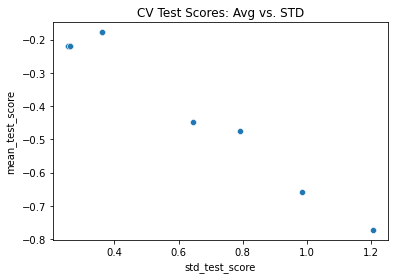

In [16]:
candidate_models = sns.scatterplot(data=resultsDF,
          x='std_test_score',
          y='mean_test_score').set(title= 'CV Test Scores: Avg vs. STD')

candidate_models;

#### Pick a Singular Optimal Model

In [17]:
fav_model = results.best_estimator_

#### Test Model on Holdout Set

In [18]:
fav_model.fit(X_train, y_train)

y_test = pd.DataFrame(y_test).reset_index()

y_test = y_test.drop('index', axis=1)

y_predictions = fav_model.predict(X_test)

#y_predictions = pd.DataFrame(y_predictions).reset_index()

r2 = r2_score(y_test, y_predictions)

print('R^2 =',r2.round(5))

R^2 = 0.00622


## Soybean Model

In [19]:
#Split off X and y
y_soy = Commodities_DF['realized_ret_soybeans'] #y
Commodities_DF_X = Commodities_DF.drop(['realized_ret_corn', 'realized_ret_soybeans', 
                                       'realized_ret_wheat'], axis=1) #x's

#Train data is first 80% of our DF, test (holdout) data is last 20% of our DF
X_train = Commodities_DF_X[0:288]
X_test = Commodities_DF_X[288:]
y_train_soy = y_soy[0:288]
y_test_soy = y_soy[288:]

In [20]:
#Building preproc_pipe
numer_pipe = make_pipeline(SimpleImputer(strategy='mean'), #pipe for numerical variables 
                           StandardScaler())  #std scaler --> mean 0, std 1

preproc_pipe = ColumnTransformer(
    [
        ("num_impute", numer_pipe, ['ret_gdp','ret_cpi','UNRATE',
                                    'S_PRCP','S_SNOW','S_TMAX',
                                    'S_TMIN','market_risk_prem'])
    ],
    remainder = 'drop' #drop any other vars not modified above
)

In [21]:
#Use pipeline to preprocess X_train
preproc_df = df_after_transform(preproc_pipe, X_train)

print(f'There are {preproc_df.shape[1]} columns in the preprocessed data.')
preproc_df.describe().T.round(2) #describe with 2 digits

There are 8 columns in the preprocessed data.


,count,mean,std,min,25%,50%,75%,max
ret_gdp,288.0,-0.0,1.0,-3.61,-0.57,-0.57,0.76,3.16
ret_cpi,288.0,-0.0,1.0,-7.55,-0.39,0.00,0.42,4.36
UNRATE,288.0,0.0,1.0,-1.45,-0.76,-0.26,0.67,2.41
S_PRCP,288.0,0.0,1.0,-0.28,-0.28,-0.28,-0.24,9.76
S_SNOW,288.0,-0.0,1.0,-0.17,-0.17,-0.17,-0.17,11.38
S_TMAX,288.0,-0.0,1.0,-2.47,-0.83,0.01,0.89,1.68
S_TMIN,288.0,0.0,1.0,-3.04,-0.65,0.00,0.85,1.71
market_risk_prem,288.0,-0.0,1.0,-2.20,-0.96,0.12,0.66,2.71


In [22]:
gbr_pipe = Pipeline([
                ('preproc', preproc_pipe),
                ('feature_select', 'passthrough'),
                ('estim', linear_model.BayesianRidge())
                ])

In [23]:
gbr_pipe.get_params()

{'memory': None,
 'steps': [('preproc',
   ColumnTransformer(transformers=[('num_impute',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    ['ret_gdp', 'ret_cpi', 'UNRATE', 'S_PRCP',
                                     'S_SNOW', 'S_TMAX', 'S_TMIN',
                                     'market_risk_prem'])])),
  ('feature_select', 'passthrough'),
  ('estim', BayesianRidge())],
 'verbose': False,
 'preproc': ColumnTransformer(transformers=[('num_impute',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer()),
                                                  ('standardscaler',
                                                   StandardScale

In [24]:
params = {'estim' : [LinearRegression(), Ridge(), linear_model.BayesianRidge(), ensemble.GradientBoostingRegressor(), ensemble.RandomForestRegressor()], 
           'preproc__num_impute__simpleimputer__strategy': ['mean', 'median']}

grid_search = GridSearchCV(estimator = gbr_pipe,    
                           param_grid = params,
                           cv = cv,
                           scoring = 'r2')

results = grid_search.fit(X_train, y_train_soy) #fitting the x and y training data 

resultsDF2 = pd.DataFrame(results.cv_results_) #convert to DF

resultsDF2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estim,param_preproc__num_impute__simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,...,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014775,0.008341,0.004774,0.002133,LinearRegression(),mean,"{'estim': LinearRegression(), 'preproc__num_im...",-3.828275,0.170633,-0.009198,...,-1.364554,-0.112015,-0.040628,-0.554775,-0.134602,0.038989,-0.171895,-0.394806,0.870656,6
1,0.011779,0.002096,0.004145,0.001853,LinearRegression(),median,"{'estim': LinearRegression(), 'preproc__num_im...",-3.803644,0.171379,-0.011338,...,-1.348492,-0.113556,-0.040604,-0.555474,-0.131276,0.036860,-0.168847,-0.392694,0.864630,5
2,0.009891,0.001928,0.003983,0.001648,Ridge(),mean,"{'estim': Ridge(), 'preproc__num_impute__simpl...",-3.726285,0.167878,-0.004976,...,-1.364248,-0.111249,-0.037968,-0.553333,-0.134376,0.038785,-0.171398,-0.387660,0.849706,4
3,0.010111,0.002526,0.005211,0.001631,Ridge(),median,"{'estim': Ridge(), 'preproc__num_impute__simpl...",-3.702246,0.168620,-0.007227,...,-1.348356,-0.112758,-0.037948,-0.554023,-0.131061,0.036670,-0.168435,-0.385598,0.843797,3
4,0.010667,0.002136,0.003439,0.000674,BayesianRidge(),mean,"{'estim': BayesianRidge(), 'preproc__num_imput...",-1.764452,0.040495,0.009350,...,-0.978404,-0.038467,-0.001888,-0.400642,-0.069186,-0.019797,-0.074889,-0.225255,0.427549,2
5,0.010549,0.001927,0.004794,0.001244,BayesianRidge(),median,"{'estim': BayesianRidge(), 'preproc__num_imput...",-1.763207,0.040742,0.008891,...,-0.976008,-0.038607,-0.001893,-0.400664,-0.068672,-0.019852,-0.074499,-0.225035,0.427110,1
6,0.060029,0.013664,0.004071,0.001597,GradientBoostingRegressor(),mean,"{'estim': GradientBoostingRegressor(), 'prepro...",-5.643769,0.105450,-0.204801,...,-1.503891,-0.310558,-0.344959,-1.580421,0.053146,0.095733,-0.092397,-0.714776,1.255781,9
7,0.059033,0.013833,0.004990,0.002229,GradientBoostingRegressor(),median,"{'estim': GradientBoostingRegressor(), 'prepro...",-5.741536,0.095330,-0.181642,...,-1.546915,-0.268760,-0.322219,-1.458673,0.046337,0.062061,-0.207237,-0.724340,1.267799,10
8,0.212750,0.030992,0.015818,0.004418,RandomForestRegressor(),mean,"{'estim': RandomForestRegressor(), 'preproc__n...",-3.146408,0.203531,-0.120771,...,-1.567871,-0.174900,-0.254018,-1.086283,-0.117800,0.003180,-0.132148,-0.479677,0.745124,8
9,0.162152,0.018848,0.011414,0.000984,RandomForestRegressor(),median,"{'estim': RandomForestRegressor(), 'preproc__n...",-2.612371,0.171506,-0.184220,...,-1.705708,-0.121372,-0.218380,-1.009399,-0.099377,-0.040326,-0.064340,-0.446981,0.663801,7


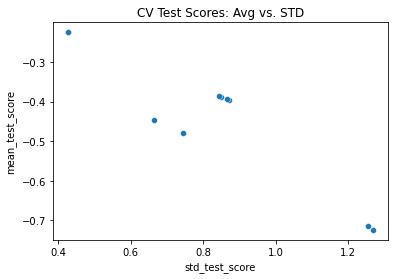

In [25]:
candidate_models = sns.scatterplot(data=resultsDF2,
          x='std_test_score',
          y='mean_test_score').set(title= 'CV Test Scores: Avg vs. STD')

candidate_models;

#### Pick a Singular Optimal Model

In [26]:
fav_model2 = results.best_estimator_

#### Test Model on Holdout Set

In [27]:
fav_model2.fit(X_train, y_train_soy)

y_test_soy = pd.DataFrame(y_test_soy).reset_index()

y_test_soy = y_test_soy.drop('index', axis=1)

y_predictions = fav_model.predict(X_test)

r2 = r2_score(y_test_soy, y_predictions)

print('R^2 =',r2.round(5))

R^2 = -0.00307


## Wheat Model

In [28]:
#Split off X and y
y_wheat = Commodities_DF['realized_ret_wheat'] #y
Commodities_DF_X = Commodities_DF.drop(['realized_ret_corn', 'realized_ret_soybeans', 
                                       'realized_ret_wheat'], axis=1) #x's

#Train data is first 80% of our DF, test (holdout) data is last 20% of our DF
X_train = Commodities_DF_X[0:288]
X_test = Commodities_DF_X[288:]
y_train_wheat = y_wheat[0:288]
y_test_wheat = y_wheat[288:]

In [29]:
#Building preproc_pipe
numer_pipe = make_pipeline(SimpleImputer(strategy='mean'), #pipe for numerical variables 
                           StandardScaler())  #std scaler --> mean 0, std 1

preproc_pipe = ColumnTransformer(
    [
        ("num_impute", numer_pipe, ['ret_gdp','ret_cpi','UNRATE',
                                    'W_PRCP','W_SNOW','W_TMAX',
                                    'W_TMIN','market_risk_prem'])
    ],
    remainder = 'drop' #drop any other vars not modified above
)

In [30]:
#Use pipeline to preprocess X_train
preproc_df = df_after_transform(preproc_pipe, X_train)

print(f'There are {preproc_df.shape[1]} columns in the preprocessed data.')
preproc_df.describe().T.round(2) #describe with 2 digits

There are 8 columns in the preprocessed data.


,count,mean,std,min,25%,50%,75%,max
ret_gdp,288.0,-0.0,1.0,-3.61,-0.57,-0.57,0.76,3.16
ret_cpi,288.0,-0.0,1.0,-7.55,-0.39,0.00,0.42,4.36
UNRATE,288.0,0.0,1.0,-1.45,-0.76,-0.26,0.67,2.41
W_PRCP,288.0,-0.0,1.0,-0.38,-0.38,-0.38,-0.16,10.23
W_SNOW,288.0,-0.0,1.0,-0.15,-0.15,-0.15,-0.15,14.05
W_TMAX,288.0,0.0,1.0,-2.65,-0.84,-0.11,0.93,2.07
W_TMIN,288.0,0.0,1.0,-4.69,-0.71,-0.03,0.73,2.33
market_risk_prem,288.0,-0.0,1.0,-2.20,-0.96,0.12,0.66,2.71


In [31]:
gbr_pipe = Pipeline([
                ('preproc', preproc_pipe),
                ('feature_select', 'passthrough'),
                ('estim', linear_model.BayesianRidge())
                ])

In [32]:
gbr_pipe.get_params()

{'memory': None,
 'steps': [('preproc',
   ColumnTransformer(transformers=[('num_impute',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    ['ret_gdp', 'ret_cpi', 'UNRATE', 'W_PRCP',
                                     'W_SNOW', 'W_TMAX', 'W_TMIN',
                                     'market_risk_prem'])])),
  ('feature_select', 'passthrough'),
  ('estim', BayesianRidge())],
 'verbose': False,
 'preproc': ColumnTransformer(transformers=[('num_impute',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer()),
                                                  ('standardscaler',
                                                   StandardScale

In [33]:
params = {'estim' : [LinearRegression(), Ridge(), linear_model.BayesianRidge(), ensemble.GradientBoostingRegressor(), ensemble.RandomForestRegressor()], 
           'preproc__num_impute__simpleimputer__strategy': ['mean', 'median']}

grid_search = GridSearchCV(estimator = gbr_pipe,    
                           param_grid = params,
                           cv = cv,
                           scoring = 'r2')

results = grid_search.fit(X_train, y_train_wheat) #fitting the x and y training data 

resultsDF3 = pd.DataFrame(results.cv_results_) #convert to DF

resultsDF3

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estim,param_preproc__num_impute__simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,...,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008445,0.002948,0.003533,0.001081,LinearRegression(),mean,"{'estim': LinearRegression(), 'preproc__num_im...",-0.015945,-0.261898,-0.067152,...,-0.406670,-0.433202,-0.081815,-0.269487,-0.072989,0.029535,-0.190148,-0.116019,0.173794,5
1,0.007327,0.000979,0.003039,0.000474,LinearRegression(),median,"{'estim': LinearRegression(), 'preproc__num_im...",-0.013811,-0.283718,-0.083211,...,-0.405892,-0.429013,-0.083405,-0.268089,-0.074240,0.032183,-0.187578,-0.116331,0.171141,6
2,0.011343,0.001192,0.003150,0.000359,Ridge(),mean,"{'estim': Ridge(), 'preproc__num_impute__simpl...",-0.003603,-0.256474,-0.066968,...,-0.405437,-0.431120,-0.081445,-0.268935,-0.073048,0.028371,-0.191356,-0.114297,0.173090,3
3,0.012623,0.003090,0.004399,0.002090,Ridge(),median,"{'estim': Ridge(), 'preproc__num_impute__simpl...",-0.001452,-0.276350,-0.082292,...,-0.404562,-0.426869,-0.083022,-0.267612,-0.074348,0.030896,-0.188857,-0.114589,0.170373,4
4,0.010347,0.003001,0.005433,0.002435,BayesianRidge(),mean,"{'estim': BayesianRidge(), 'preproc__num_imput...",-0.100183,-0.149638,-0.009772,...,-0.353352,-0.277482,-0.038362,-0.183642,-0.044680,-0.012001,-0.333939,-0.095570,0.120200,1
5,0.011744,0.002098,0.004430,0.001633,BayesianRidge(),median,"{'estim': BayesianRidge(), 'preproc__num_imput...",-0.099584,-0.153256,-0.011248,...,-0.351554,-0.273192,-0.038686,-0.182380,-0.044953,-0.012591,-0.335872,-0.096214,0.118666,2
6,0.066434,0.007820,0.004578,0.001399,GradientBoostingRegressor(),mean,"{'estim': GradientBoostingRegressor(), 'prepro...",-1.127555,-0.442507,-0.894046,...,-0.338850,-0.608755,-0.006938,-0.391562,-0.437810,0.119553,0.154117,-0.325755,0.352735,10
7,0.064039,0.013592,0.004231,0.001389,GradientBoostingRegressor(),median,"{'estim': GradientBoostingRegressor(), 'prepro...",-0.910540,-0.188569,-0.989828,...,-0.235748,-0.538632,-0.077339,-0.281893,0.031841,0.179179,0.299286,-0.257180,0.330439,9
8,0.183760,0.035240,0.012813,0.002328,RandomForestRegressor(),mean,"{'estim': RandomForestRegressor(), 'preproc__n...",-0.499663,-0.172361,-0.427476,...,-0.434554,-0.441291,-0.108115,-0.266206,-0.211757,-0.131220,0.071997,-0.221460,0.169667,8
9,0.166777,0.017238,0.011424,0.001018,RandomForestRegressor(),median,"{'estim': RandomForestRegressor(), 'preproc__n...",-0.314413,-0.206304,-0.466300,...,-0.272914,-0.440854,-0.040170,-0.274990,-0.005577,0.088598,0.210758,-0.187220,0.182271,7


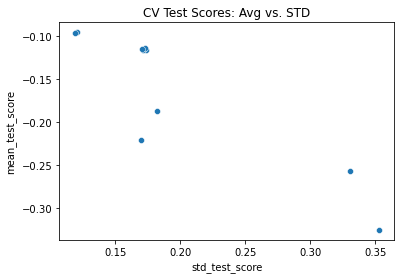

In [34]:
candidate_models = sns.scatterplot(data=resultsDF3,
          x='std_test_score',
          y='mean_test_score').set(title= 'CV Test Scores: Avg vs. STD')

candidate_models;

#### Pick a Singular Optimal Model

In [35]:
fav_model3 = results.best_estimator_

#### Test Model on Holdout Set

In [36]:
fav_model3.fit(X_train, y_train_wheat)

y_test_wheat = pd.DataFrame(y_test_wheat).reset_index()

y_test_wheat = y_test_wheat.drop('index', axis=1)

y_predictions = fav_model.predict(X_test)

r2 = r2_score(y_test_wheat, y_predictions)

print('R^2 =',r2.round(5))

R^2 = 0.00136
